# Tree-Based Methods

We will be using the `tree` library to construct classification and regression trees.

In [2]:
# install.packages('tree')
library(tree)

First, we'll use classification trees to analyze the `Carseats` dataset. In this dataset, `Sales` is a continuous variable, and so we will begin by recoding it as a binary variable that takes on a value of `Yes` if the `Sales` variable exceeds 8, and takes on a value of `No` otherwise.  


In [3]:
library(ISLR)
attach(Carseats)

# Create binary variable to indicate high or low sales
High <- ifelse(Sales <= 8, 'No', 'Yes')

# Merge this column with the Carseats dataset
Carseats <- data.frame(Carseats, High)

Now we'll use the `tree()` function to fit a classification tree too predict `High` using all variables (except `Sales`, of course). The syntax of the `tree()` function is quite similar to that of the `lm()` function.  

In [4]:
tree.carseats <- tree(High ~ . - Sales, data=Carseats)

The `summary()` function lists the variables that are used as internal nodes in the tree, the number of internal nodes, and the training errorr rate.

In [5]:
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

We can see above that the training error rate is 9%. For classification trees, the deviance reported in the output of `summary()` is given by $$-2\sum_{m}\sum_kn_{mk}log\hat{p}_{mk},$$ where $n_{mk}$ is the number of observations in the $m$th terminal node that belong to the $k$th class. A small deviance indicates a tree that provides a good fit to the training data. The *residual mean deviance* reported is simply the deviance divided by $n - |T_0|$, which in this case is 400-27 = 373.  
  
  One of the most attractive properties of trees is that they can be graphically displayed. We use the `plot()` function to display the tree structure and the `text()` function to display the node labels. The argument `pretty=0` instructs `R` to include the category names forr any qualitative predictors, rather than just displaying a letter for each category.

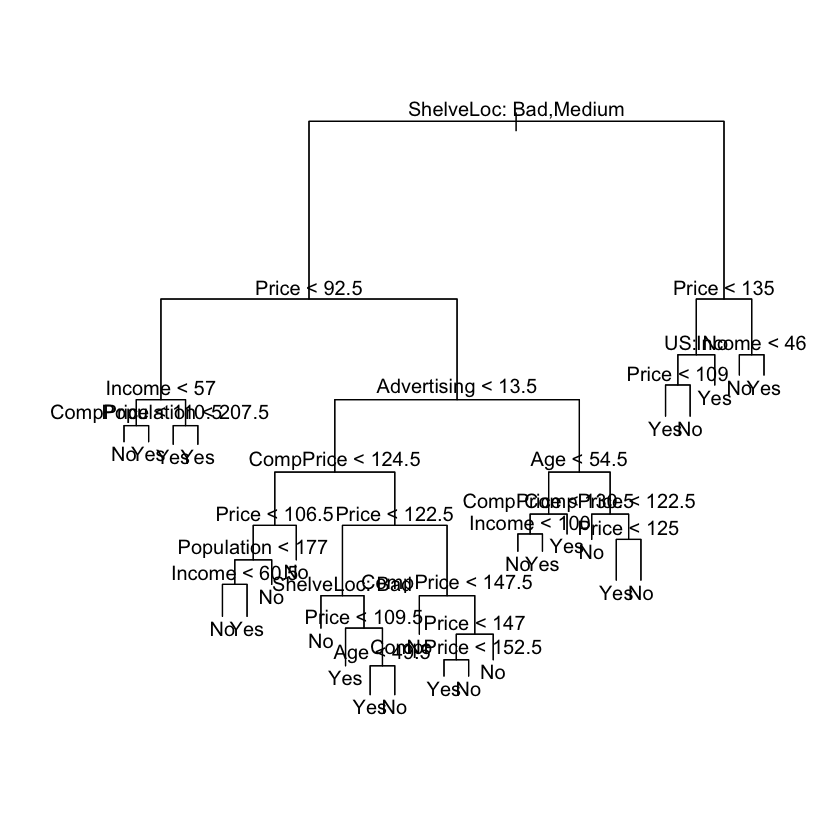

In [6]:
plot(tree.carseats)
text(tree.carseats, pretty=0)

We can see from the above tree that the most important indicator of `Sales` appears to be shelving location (`ShelveLoc`), since the first branch differentiates `Good` locations (right) from `Bad` and `Medium` locations (left).  
  
  If we just type the name of the tree object, `R` prints output corresponding to each branch of tree. `R` displays the split criterion (e.g., `Price<92.5`), the number of observations in that branch, the deviance, the overall prediction for the branch (`Yes` or `No`), and the fraction of observations in that branch that take on values of `Yes` and `No`. Branches that lead to terminal nodes are indicated using asterisks.  

In [7]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

To properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error. We split the observations into a trraining set and a test set, build the tree using the training set and test it on the test set (lol duh). The `predict()` function can be used for this purpose. In the case of a classification tree, the argument `type='class'` intructs `R` to returrn the actual class prediction.

In [8]:
# Set seed and split into test/train sets
set.seed(2)
train <- sample(1:nrow(Carseats), 200)
Carseats.test <- Carseats[-train,]
High.test <- High[-train]

# Build model and make predictions
tree.carseats <- tree(High ~ . -Sales, data=Carseats, subset=train)
tree.pred <- predict(tree.carseats, Carseats.test, type='class')

# Create confusion Matrix
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  104  33
      Yes  13  50

In [9]:
(104 + 50) / 200

[1] 0.77

Using this model we obtain a 77% accuracy rate on the test data.  

Next, we consider whether pruning the tree might lead to better results. The function `cv.tree()` performs cross-validation in order to determine the optimal level of tree complexity. Cost complexity pruning is used to select a sequence of trees for consideration. We use the argument `FUN=prune.misclass` in order to indicate that we want the classification error rate to guide the cross-validation and pruning process, rather than the defaul for the `cv.tree()` function, which is deviance. The `cv.tree()` function reports the number of terminal nodes of each treed considered (`size`) as well as the corresponding error rate and the value of the cost-complexity parameter used (`k`).

In [11]:
set.seed(13)
cv.carseats <- cv.tree(tree.carseats, FUN=prune.misclass)
names(cv.carseats)

[1] "size"   "dev"    "k"      "method"

In [13]:
cv.carseats

$size
[1] 21 19 14  9  8  5  3  2  1

$dev
[1] 64 65 63 63 72 81 85 88 82

$k
[1] -Inf  0.0  1.0  1.4  2.0  3.0  4.0  9.0 18.0

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

Despite the name, `dev` here corresponds to the cross-validation rate. The tree with 9 terminal nodes results in the lowest cross-validation error rate, with 63 cross-validation errors. Next we plot the error rate as a function of both `size` and `k`.

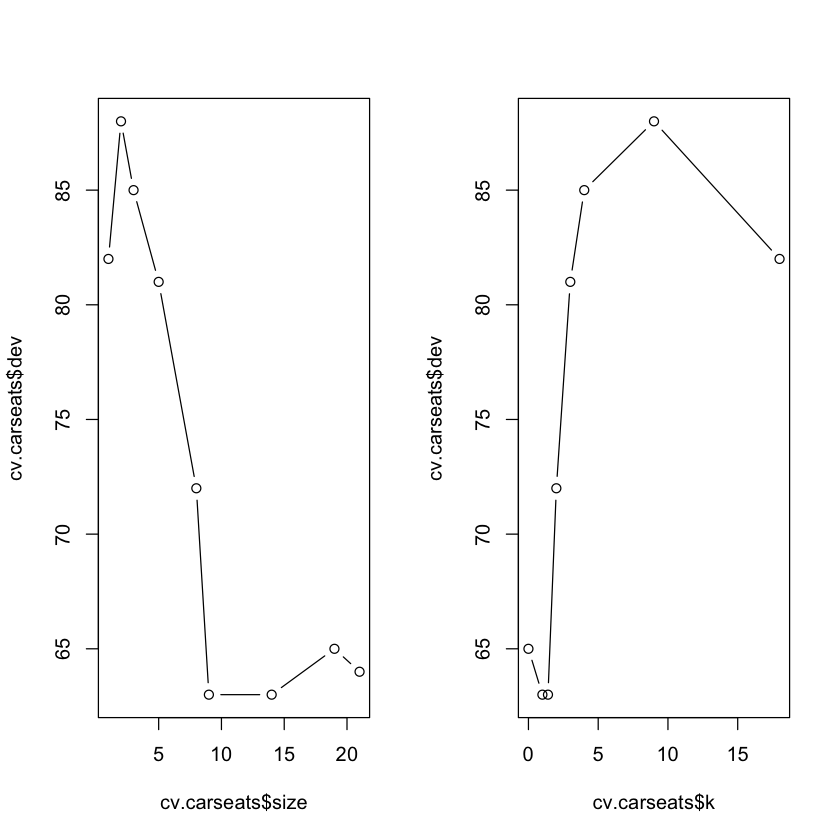

In [14]:
par(mfrow=c(1,2))
plot(cv.carseats$size, cv.carseats$dev, type='b')
plot(cv.carseats$k, cv.carseats$dev, type='b')

Now we apply the `prune.misclass()` function in order to prune the tree to obtain the nine-node tree.

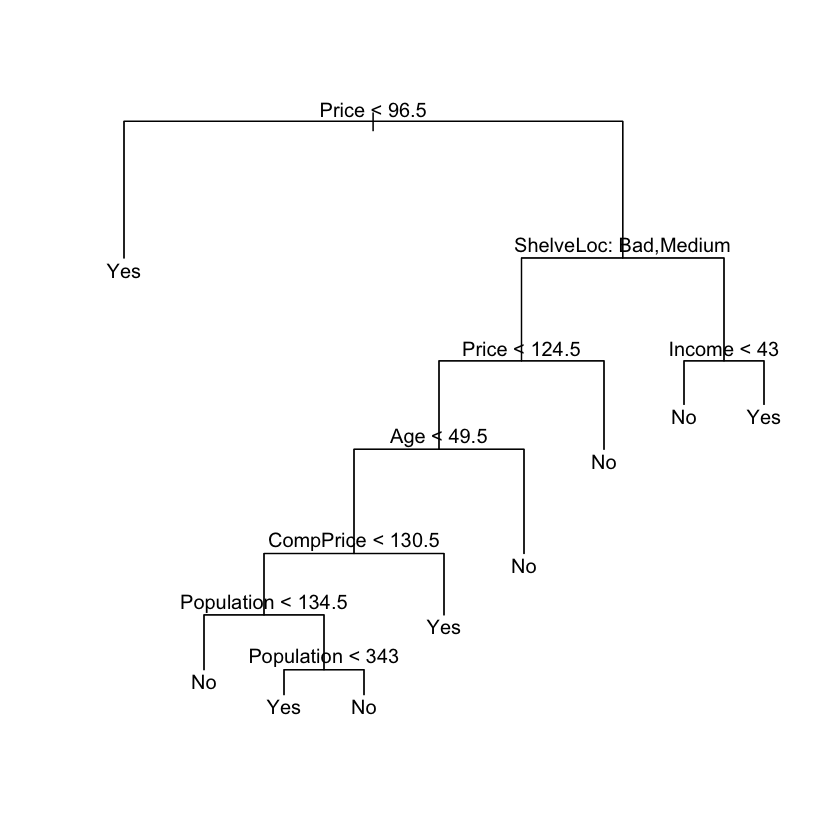

In [17]:
prune.carseats <- prune.misclass(tree.carseats, best=9)
plot(prune.carseats)
text(prune.carseats, pretty=0)

Now we use the `predict()` function to see how well the pruned tree performs on the test data set.

In [18]:
tree.pred <- predict(prune.carseats, Carseats.test, type='class')
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  97  25
      Yes 20  58

In [19]:
(97 + 58) / 200

[1] 0.775

Our results are only marginally better than the unpruned tree predictions, but we also have a much less complex and more interpretable model.  
  
  If we increase the value of `best` (terminal nodes), we obtain a larger pruned tree:

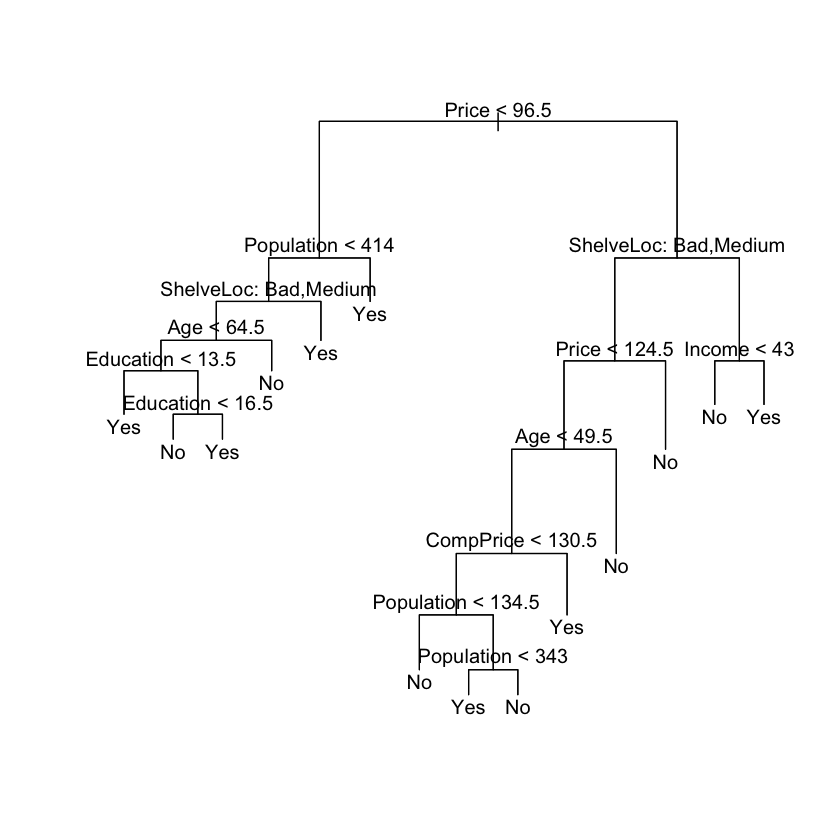

In [25]:
prune.carseats <- prune.misclass(tree.carseats, best=14)
plot(prune.carseats)
text(prune.carseats, pretty=0)

In [21]:
tree.pred <- predict(prune.carseats, Carseats.test, type='class')
table(tree.pred, High.test)

         High.test
tree.pred  No Yes
      No  102  31
      Yes  15  52

In [22]:
(102+52)/200

[1] 0.77

##  
  
  

## Fitting Regression Trees

Next we will fit a regression tree to the `Boston` dataset. First, we create a training set and fit the tree to the training data.

In [27]:
library(MASS)
attach(Boston)

set.seed(138)
train <- sample(1:nrow(Boston), nrow(Boston)/2)
tree.boston <- tree(medv ~ ., Boston, subset=train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "lstat" "rm"    "dis"   "crim" 
Number of terminal nodes:  10 
Residual mean deviance:  12.53 = 3045 / 243 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-10.4600  -2.1320   0.1841   0.0000   2.0680  17.4400 

Notice that the output of `summary()` indicates tat only four of the variables have been used in constructing the tree. In the context of a regression tree, the deviance is simply the sum of squared errors for the tree. We now plot the tree:

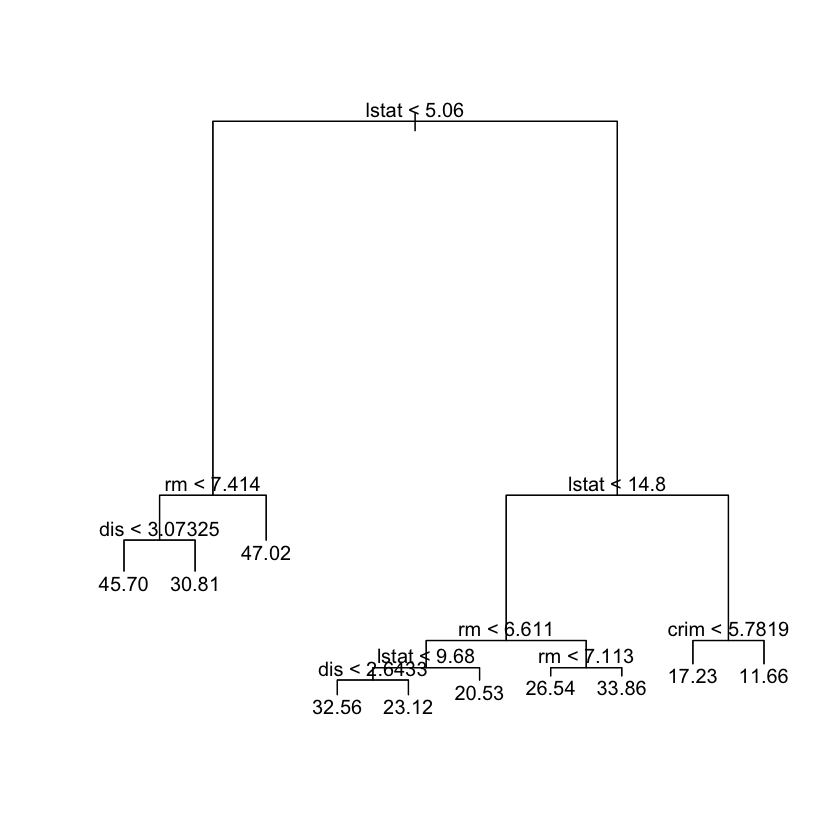

In [28]:
plot(tree.boston)
text(tree.boston, pretty=0)

The variable `lstat` measures the percentage of individuals with low socioeconomic status. The tree indicates that lower values of `lstat` correspond to more expensive houses. The tree predicts a median house price of $47,200 for large homes in which residents have high socioeconomic status (`rm>=7.414` and `lstat<5.06`).  
  
  Now we use `cv.tree()` to see whether pruning the tree will improve performance.

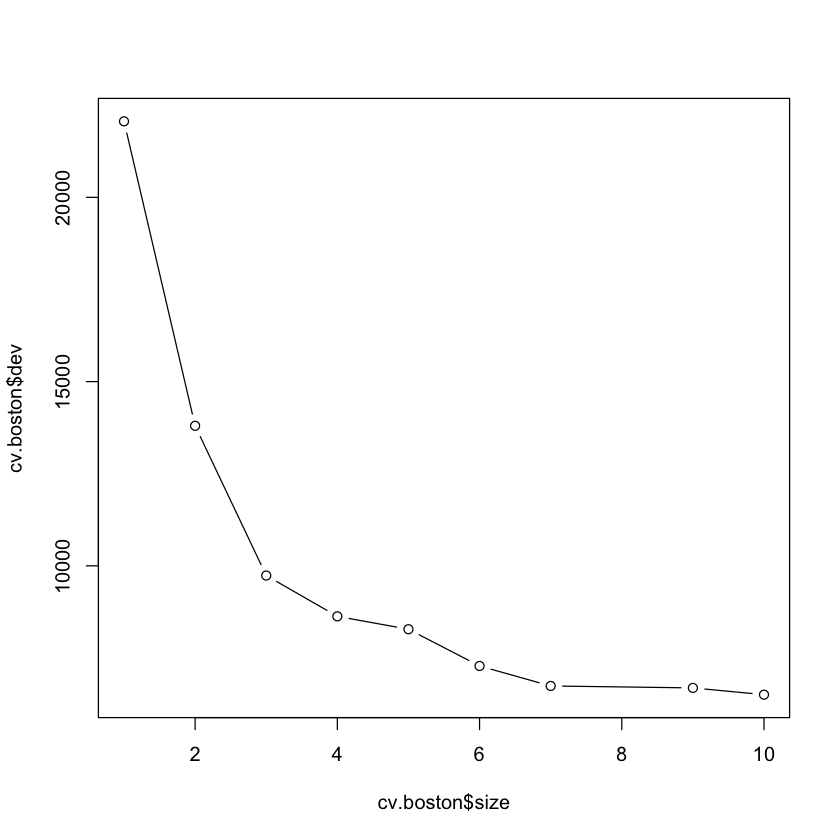

In [29]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type='b')

In this case, the most complex tree (10 terminal nodes) is chosen by cross-validation. However, if we wish to prune the tree for a simpler model, we could do as follows, using the `prune.tree()` function:

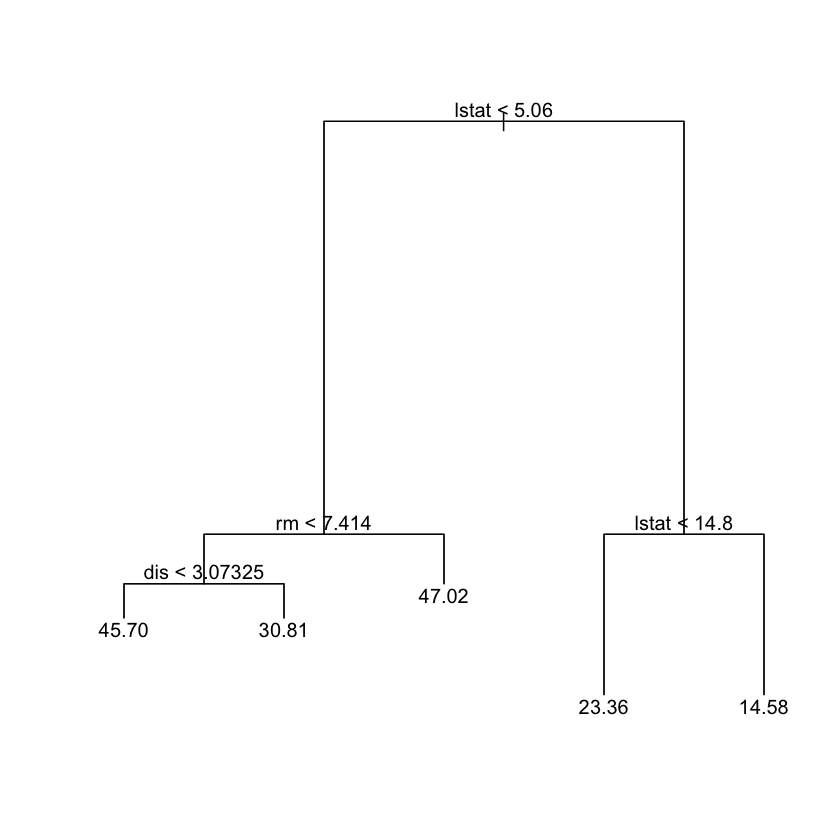

In [30]:
prune.boston <- prune.tree(tree.boston, best=5)
plot(prune.boston)
text(prune.boston, pretty=0)

Now let's use the unpruned tree to make predictions on the test set.

[1] 20.09695

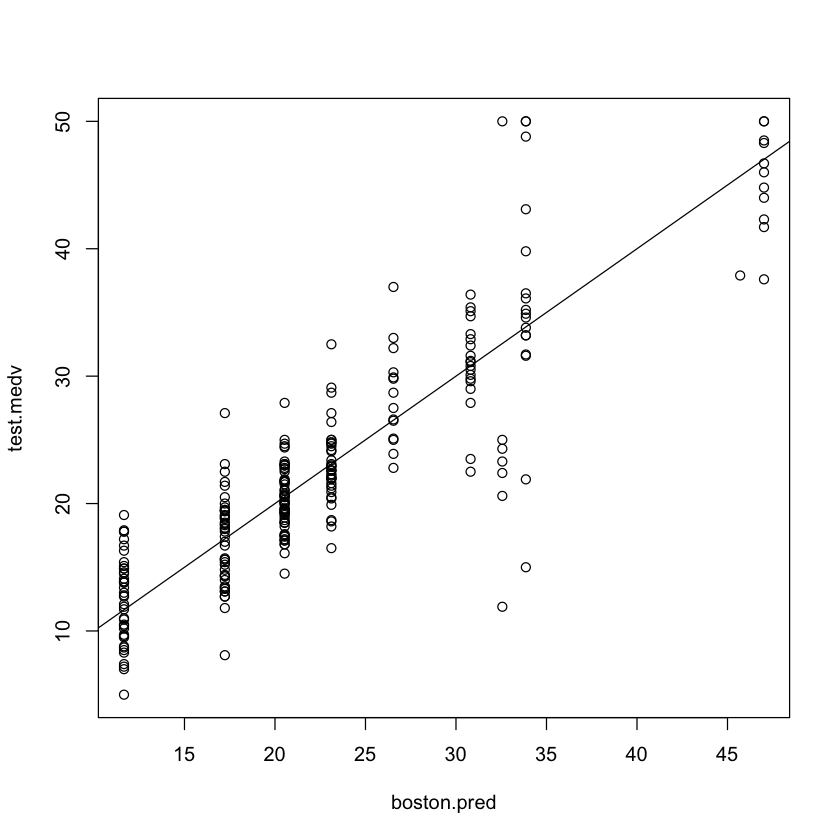

In [31]:
boston.pred <- predict(tree.boston, Boston[-train,])
test.medv <- Boston[-train,'medv']
plot(boston.pred, test.medv)
abline(0,1)

In [32]:
mean((test.medv - boston.pred)^2)

[1] 20.09695

We can see above that the MSE associated with this regression tree is 20.097. The RMSE is therefore $\sqrt{20.097} \approx 4.483$, indicating that this model leads to test predictions that are within around $4,483 of the true median home value.

##  
  
  

## Bagging and Random Forests

Next, we'll apply bagging and random forests to the `Boston` dataset, using the `randomForest` library. Recall that bagging is simply a special case of a random forest with $m=p$. Therefore, the `randomForest()` function can be used to perform both random forests and bagging. We perform bagging as follows:

In [34]:
#install.packages('randomForest')
library(randomForest)
set.seed(5150)

bag.boston <- randomForest(medv ~ ., data=Boston, subset=train, mtry=13, importance=TRUE)
bag.boston

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.



Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 12.95414
                    % Var explained: 84.85

The argument `mtry=13` indicates that all 13 predictors should be considered for each split of the tree--In other words, that we are bagging. How well does the bagged model perform on the test set?

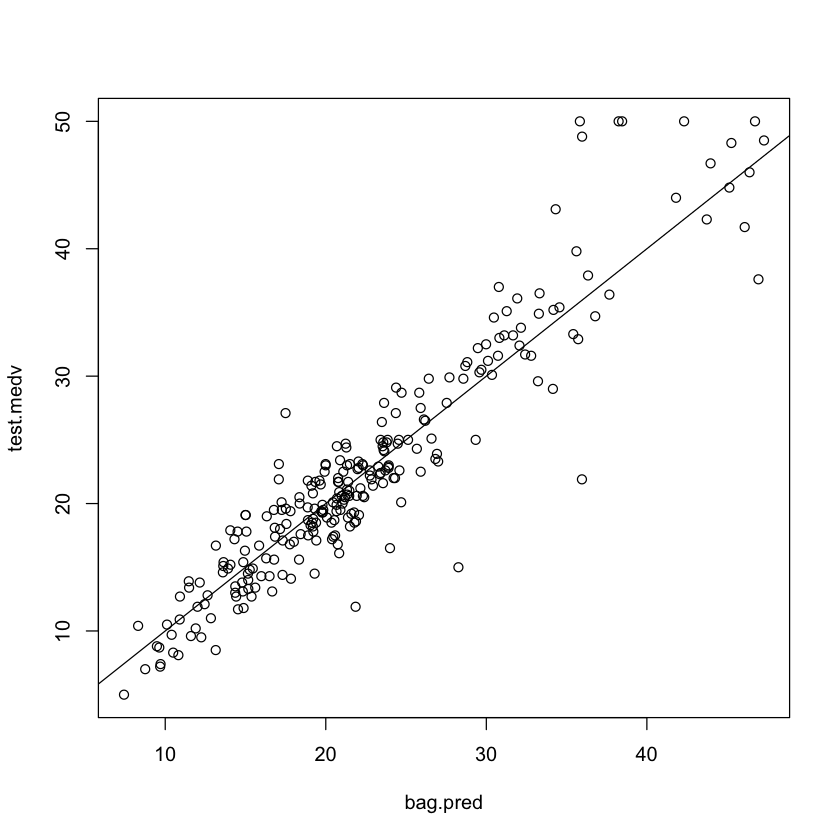

In [35]:
bag.pred <- predict(bag.boston, Boston[-train,])
plot(bag.pred, test.medv)
abline(0,1)

In [36]:
mean((test.medv - bag.pred)^2)

[1] 10.61685

The test MSE associated with the bagged regression tree is 10.617, about half that obtained using a single tree. We could change the number of trees grown by `randomForest()` using the `ntree` argument:

In [41]:
bag.boston <- randomForest(medv ~ ., data=Boston, subset=train, mtry=13, ntree=25)
bag.pred <- predict(bag.boston, Boston[-train,])
mean((test.medv - bag.pred)^2)

[1] 12.63951

Growing a random forest proceeds in exactly the same way, except that we use a smaller value of the `mtry` argument. By default, `randomForest()` uses $p/3$ variables when building a random forest of regression trees, and $\sqrt{p}$ variables when building a random forest of classification trees. Here we use `mtry=6`.

In [42]:
set.seed(999)
rf.boston <- randomForest(medv ~ ., data=Boston, subset=train, mtry=6, importance=TRUE)

rf.pred <- predict(rf.boston, Boston[-train,])
mean((test.medv - rf.pred)^2)

[1] 11.16156

We can see above that in this case, the test MSE from the random forest is close to the test MSE obtained using bagging.  
  
  Using the `importance()` function, we can view the importance of each variable:

In [43]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,12.743574,1355.39474
zn,1.795411,58.24318
indus,10.102975,797.03868
chas,2.903770,140.86134
nox,15.199219,1486.15475
rm,24.809378,5042.56029
age,10.382104,536.18125
dis,14.405999,1498.36764
rad,3.513191,81.97391
tax,7.897805,472.91567


Two measures of importance are reported above. The first is based upon the mean decrease of accuracy in prediction on the out of bag samples when a given variable is excluded from the model. The second is a measure of the total decrease in node impurity that results from splits over that variable, averaged over all trees. In the case of regression trees, the node impurity is measured by the training RSS, and for classificatiton trees by the deviance. Plots of these measures can be produced using the `varImpPlot()` function.

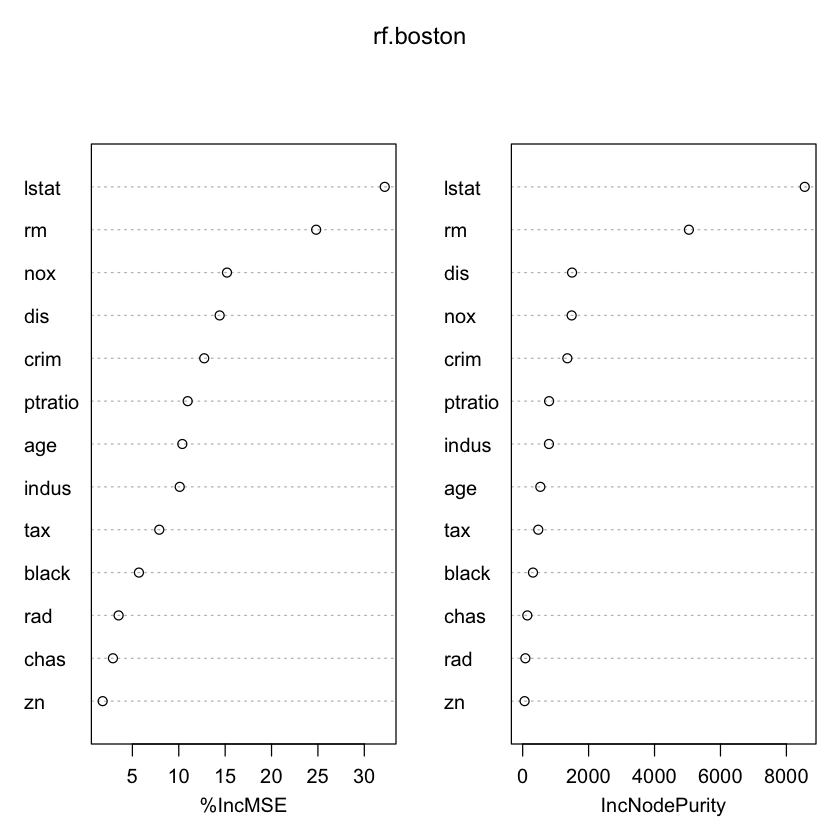

In [44]:
varImpPlot(rf.boston)

The results indicate that across all of the trees considered in the random forest, the wealth level of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.  
  
  

##  
  
  

## Boosting

Here we will use the `gbm` library and the `gbm()` function to fit boosted regression trees to the `Boston` dataset. We run `gbm()` with the option `distribution='gaussian'` since this is a regression problem. If it were a binary classification problem, we would use `distribution='bernoulli'`. The arrgument `n.trees=5000` indicates that we want 5000 trees, and the option `interaction.depth=4` limits the depth of each tree.

In [47]:
# install.packages('gbm')
library(gbm)
set.seed(31)
boost.boston <- gbm(medv ~ ., data=Boston[train,], distribution='gaussian', n.trees=5000, interaction.depth=4)

Loaded gbm 2.1.8


The `summary()` function produces a relative influence plot and also outputs the relative influence statistics.

,var,rel.inf
lstat,lstat,47.1015943
rm,rm,19.2245693
dis,dis,11.1916581
crim,crim,4.7171714
black,black,3.8874506
nox,nox,3.4157202
ptratio,ptratio,2.8278079
age,age,2.4551971
indus,indus,1.8816257
tax,tax,1.6368005


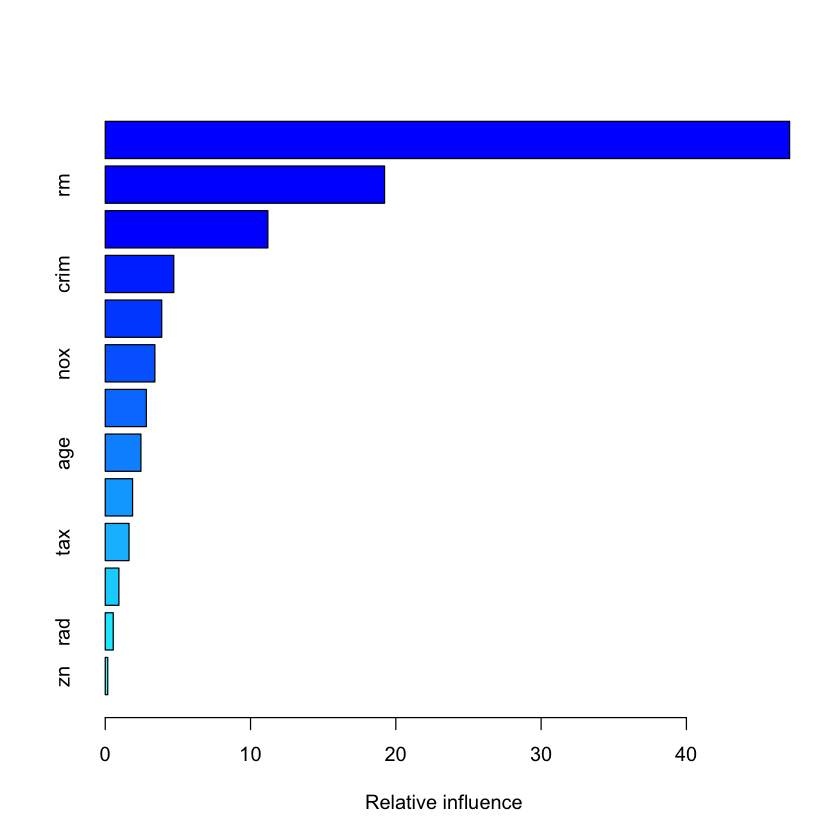

In [48]:
summary(boost.boston)

We see again that `lstat` and `rm` are the most important variables. We can also produce *partial dependence plots* for these two variables. These plots illustrate the marginal effect of the selected variables on the response after *integrating* out the other variables.

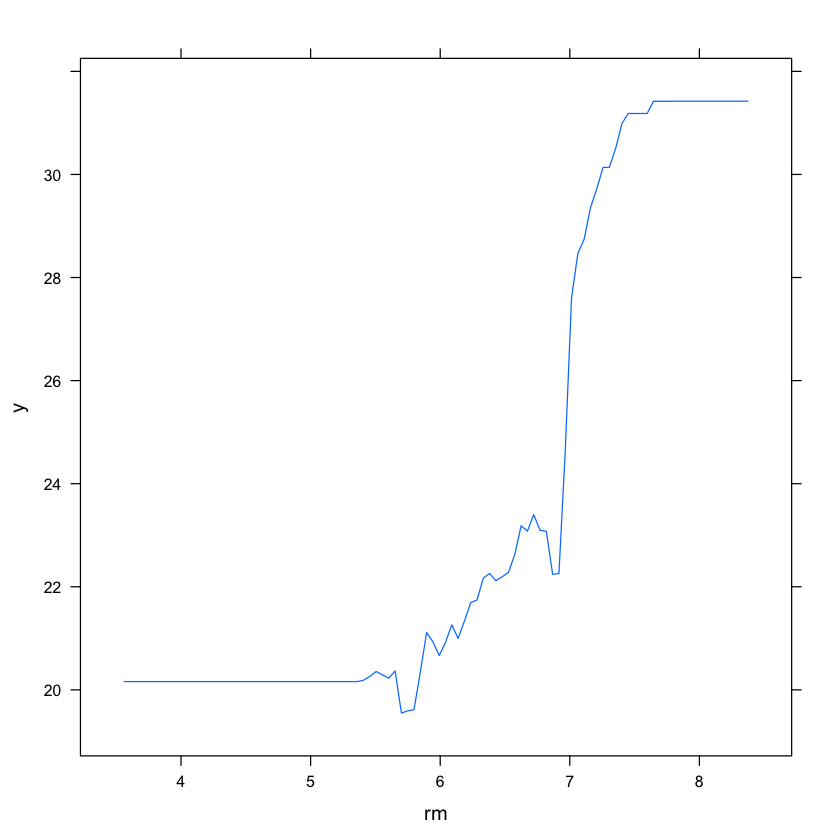

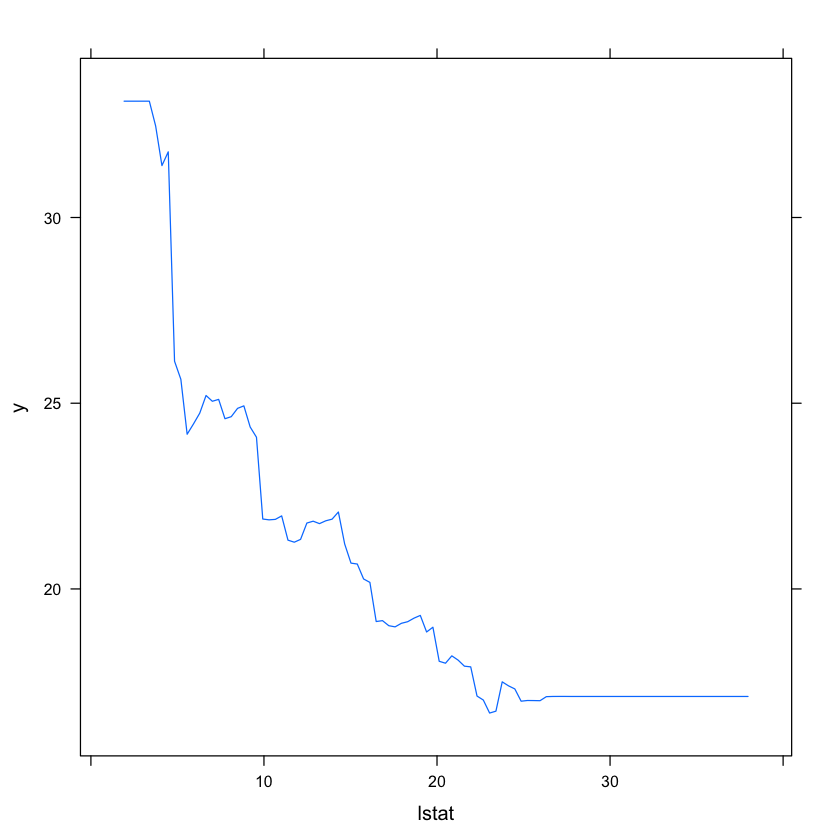

In [52]:
par(mfrow=c(1,2))
plot(boost.boston, i='rm')
plot(boost.boston, i='lstat')

We can see in the plots above that, as we might expect, median house prices are increasing with `rm` and decreasing with `lstat`.  
  
  We now use the boosted model to predict `medv` on the test set:

In [53]:
boost.pred <- predict(boost.boston, newdata=Boston[-train,], n.trees=5000)
mean((test.medv - boost.pred)^2)

[1] 13.84666

The test MSE from the boosted model is 13.847, slightly worse than the test MSE for random forests and bagging. If we want to, we can perform boosting with a different value of the shrinkage parameter $\lambda$. The default value is 0.001, but this is easily modified. Here we use $\lambda = 0.2$.

In [54]:
boost.boston <- gbm(medv ~ ., data=Boston[train,], distribution='gaussian', n.trees=5000, 
                    interaction.depth=4, shrinkage=0.2, verbose=FALSE)
boost.pred <- predict(boost.boston, newdata=Boston[-train,], n.trees=5000)
mean((test.medv - boost.pred)^2)

[1] 14.59236

In this case, using $\lambda = 0.2$ leads to a slightly larger test MSE than $\lambda = 0.001$.